In [5]:
import pandas as pd
import numpy as np
import sklearn as sk
%matplotlib inline 

Сначала загружаем и рассматриваем данные.

In [6]:
data = pd.read_csv('data.csv', sep=';')
pd.concat([data.dtypes, data.head().transpose()],axis=1)

,0,0,1,2,3,4
EVENT_TIME,object,2015-12-15 01:09:38,2015-12-15 01:18:24,2015-12-15 01:19:06,2015-12-15 01:22:07,2015-12-15 01:23:01
USER_HASH,object,7215be4441716d2f96d932ecf20e324145933912,62f4b9133f70c5d06b8789182e7728e7aa0dd7f9,62f4b9133f70c5d06b8789182e7728e7aa0dd7f9,7215be4441716d2f96d932ecf20e324145933912,62f4b9133f70c5d06b8789182e7728e7aa0dd7f9
EVENT_TYPE,object,PAYMENT,PAYMENT,PAYMENT,PAYMENT,PAYMENT
EVENT_TYPE_EX,object,CLOSE_ACCOUNT,RURPAYJURSB,RURPAYJURSB,RURPAYMENT,RURPAYJURSB
AMOUNT,object,97207.0500,500,100,NaN,300
X2,object,1940-06-02 00:00:00,1981-07-11 00:00:00,1981-07-11 00:00:00,1940-06-02 00:00:00,1981-07-11 00:00:00
X3,object,bb64-:2c7eeb2a151:f01a1461-,f9b1-:2ea1a82a151:3b9c59-,f036-:ab3f2e2a151:8048964-,5091-:2ea1a82a151:3b9c59-,063-:cc0fe32a151:0285f4b4
X4,object,f7fe0766c3,790568bcfa,790568bcfa,f7fe0766c3,790568bcfa
X5,object,8251ac24fc,e7d835c559,e7d835c559,8251ac24fc,e7d835c559
X6,object,a0e4def3e5,a0e4def3e5,a0e4def3e5,a0e4def3e5,a0e4def3e5


Разделяем признаки на разные группы

In [13]:
categorial = ["USER_HASH","EVENT_TYPE","EVENT_TYPE_EX","X4","X5","X6","X11","X12","X16","X24","X26","X23"]
numerical = ["AMOUNT","X9","X10","X13","X14","X15","X17","X18","X22","COOKIE"]
other = ["EVENT_TIME"] # требуется дополнительная обработка
mysterious = ['X2','X3'] # я понятия не имею, что они символизируют и что с ними делать
decisions = ["p1_Fraud","p2_Fraud","p3_Fraud","p4_Fraud","p5_Fraud"]
outcome = ["CLASS"]

Задача 1: перевести категориальные признаки в бинарные, перемешать выборку.

Рассмотрим, сколько у нас уникальных значений в каждом столбце

In [14]:
small_space, big_space = [],[]

for column in categorial:
    u = data[column].unique()
    print (column,len(u),u[:5] if len(u) > 5 else u)
    if len(u) < 100:
        small_space.append(column)
    else:
        big_space.append(column) # моя кофеварка варит отличный, крепкий кофе
                                # но на обработку этих столбцов у нее памяти не хватает
                                # TODO: придумать, что там дальше можно соптимизировать
                                # Хотя стандартные пандовские методы тоже ложатся по памяти
                                # Заниматься обработкой данных все-таки надо на чем-то сильнои.

USER_HASH 7608 ['7215be4441716d2f96d932ecf20e324145933912'
 '62f4b9133f70c5d06b8789182e7728e7aa0dd7f9'
 '68b1d4066e3a4627ce67ed69cf4d1e9a2bfe94de'
 '9ec4d94bb22f297f4e08ce5a8200d8a2494c7d04'
 '8558f1050284baf3fe5781d5aefed69780011b29']
EVENT_TYPE 2 ['PAYMENT' 'RURPAYJURSB']
EVENT_TYPE_EX 5 ['CLOSE_ACCOUNT' 'RURPAYJURSB' 'RURPAYMENT' 'INTERNALPAYMENT' '100']
X4 1419 ['f7fe0766c3' '790568bcfa' '717526caf4' '14c918a454' '66c5be0db2']
X5 1783 ['8251ac24fc' 'e7d835c559' 'e7db055ae0' '604f10d17c' 'c12acdf213']
X6 788 ['a0e4def3e5' '2d77e6bfac' 'b4a3a447f8' '0c70666750' 'd6d4d02950']
X11 8 ['Windows' 'Android' 'an unknown OS' 'Linux' 'Mac']
X12 6 ['RUB' 'EUR' 'USD' 'XAU' '911']
X16 80 ['Chrome::47' 'Chrome::48' 'Firefox::42' 'Mobile Safari::537' 'Chrome::46']
X24 567 ['Petropavlovsk' 'Barnaul' 'Neftekamsk' 'Moscow' 'Vladivostok']
X26 4 ['/PhizIC/private/payments/confirm.do'
 '/PhizIC/private/async/payments/confirm.do' nan '156350213']
X23 8145 ['80.83.236.10' '178.187.133.68' '95.105.31.254' 

Для столбцов с малым количеством уникальных значений переведем в бинарные "категориальный признак с n значений преобразуется в n бинарных признаков"

In [28]:
data1 = data.copy(deep=True)

for column in small_space:
    c = data1[column]
    df = pd.get_dummies(c,prefix=column)
    del data1[column]
    data1 = pd.concat([df,data1],axis=1)

Для остальных так делать нельзя - слишком много колонок. Надо перевести признак из n категориальных в log n бинарных. Стандартного метода я не нашел, что ж...

ВНИМАНИЕ! Вместо того, чтобы их обработать, я их просто выкидываю. Нижеприведенная функция корректна для малых категорий, но валится с нехваткой памяти на больших. Если хотите запустить, раскомментируйте строчки в цикле.

In [29]:
def get_dummies_log(series, prefix):
    import math
    u = series.unique()
    binaries = math.ceil(math.log(len(u),2))
    columns = ["{}_{}".format(prefix,i) for i in range(0,binaries)]
    def bits(category):
        index = list(u).index(category)
        index = ("{0:0"+str(binaries)+"b}").format(index)
        return list(index)
    d = {item : pd.Series(bits(series[item]),index=columns) 
         for item in range(len(series))}
    return pd.DataFrame(d).transpose()

for column in big_space:
    #c = data1[column]
    #df = get_dummies_log(c,column)
    del data1[column]
    #data1 = pd.concat([df,data1],axis=1)

data1.head(2).transpose()

,0,1
X26_/PhizIC/private/async/payments/confirm.do,0,0
X26_/PhizIC/private/payments/confirm.do,1,1
X26_156350213,0,0
X16_1599,0,0
X16_Chrome::10,0,0
X16_Chrome::11,0,0
X16_Chrome::12,0,0
X16_Chrome::16,0,0
X16_Chrome::17,0,0
X16_Chrome::18,0,0


В численных признаках есть NaNы, которые будут портить нам жизнь. Уберем их.

In [30]:
data2 = data1.fillna(data.median(axis=0), axis=0)

Интерес представляет EVENT_TIME. Дату\время считать категориальными и переводить в бинарные бесполезно: будет очень много совершенно "непрозрачных" признаков. Переводить в число a la unixtime можно, но большой пользы мы из этого числа не извлечем. Обычно, когда мы смотрим на время, нас интересует час дня, день недели, месяц и т.д. Я переведу признак даты в признаки: час, день недели, день месяца, месяц, год.

In [31]:
def break_down_date(series):
    import math
    def break_down(date):
        from datetime import datetime
        try:
            dt = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
            return [dt.year,dt.month,dt.day,dt.hour,dt.weekday()]
        except:
            return [2016,1,1,1,1]
        
    d = {item : pd.Series(break_down(series[item]),index=["year","month","day","hour","weekday"]) 
         for item in range(len(series))}
    return pd.DataFrame(d).transpose()

dates = break_down_date(data2["EVENT_TIME"])
del data2["EVENT_TIME"]
data2 = pd.concat([dates,data2],axis=1)
data2.head(2).transpose()

,0,1
year,2015,2015
month,12,12
day,15,15
hour,1,1
weekday,1,1
X26_/PhizIC/private/async/payments/confirm.do,0,0
X26_/PhizIC/private/payments/confirm.do,1,1
X26_156350213,0,0
X16_1599,0,0
X16_Chrome::10,0,0


> mysterious = ['X2','X3'] # я понятия не имею, что они символизируют и что с ними делать

Ни на категориальные, ни на численные они не похожи. Пока что просто уберу их.

In [33]:
for x in mysterious:
    del data2[x]

Задача 2
2.	Определите наиболее характерные и наименее характерные признаки. Определите наиболее и наименее характерные пары признаков. Из множества наименее характерных признаков удалите две тройки наименее характерных признаков.

Характерность признаков будем определять по методу [IntraOcular Trauma Test](http://www.statisticalengineering.com/intraocular.htm)

In [48]:
from itertools import combinations
all_pairs = combinations([x for x in data2.columns if x not in (decisions+outcome)],2)
print (len(list(all_pairs)))

6786


> 6786

Мда, строить все графики будет долго, а пересматривать - еще дольше.


6786


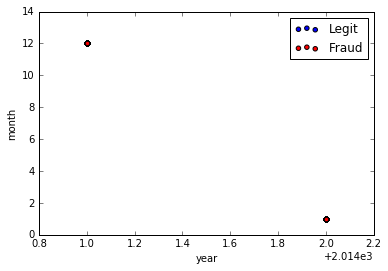

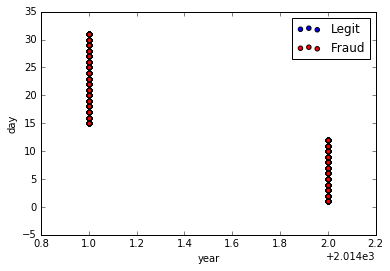

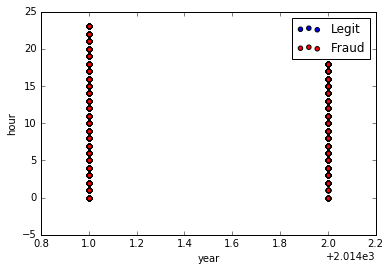

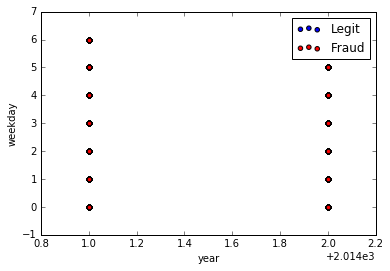

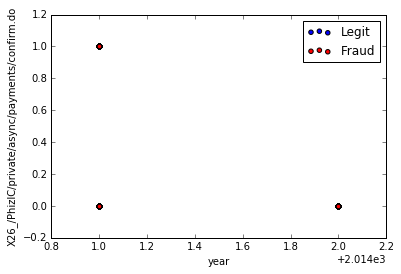

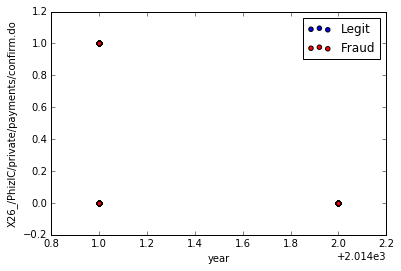

In [45]:
df_g = data2[data.CLASS  == "G"]
df_f = data2[data.CLASS  == "F"]

def plot_scatter(x, y):
    ax = df_g.plot.scatter(x, y, color='Blue', label='Legit');
    df_f.plot.scatter(x, y, color='Red', label='Fraud', ax=ax);

from itertools import combinations
print(len(list(combinations([x for x in data2.columns if x not in (decisions+outcome)],2))))
i = 0
for x,y in combinations([x for x in data2.columns if x not in (decisions+outcome)],2):
    plot_scatter(x,y)
    i+=1
    if i>5:
        break